# An overview to input datasets

LUTO-2 is version two of the Land-Use Trade-Offs model. The model predicts future spatial land-use distributions based on an economic cost-minimisation or profit-maximization logic under various constraints. Although it is a spatial model, LUTO-2 rearranges all the input data from 2D-map format into a 1D-array representation to save memory and reduce running time, making it difficult for users to intuitively understand what happened within each process. In this manual, we converts the 1D-array back to its original 2D format and visulizes how land-use change is driven by the various constrains.

```{note}
LUTO-2 is capable of running land-use change for Australia at a ~1x1 square kilometer scale, but this chapter will use a setting that specifies `RESFACTOR=5` to reduce processing time. Essentially, this resfactor means we are only using the centroid cell out of each 5*5 square matrix to run the model.

LUTO converts all input data into `numpy.ndarray` for consistent processing, but in the manual, we use `xarray.DataArray` for easier data manipulation. The main advantage of `xarray` over `numpy` is that it can create a high-dimension array (usually called a 'Tensor' or 'nd-Matrices') with sensible names.
```

In [1]:
# REMOVE

'''
Here are the code to run LUTO first, so that we can have the variables and objects required for illustration in the notebook.
'''

# Reload all modules before excuting each cell, so that we can modify the imported custom functions on-the-fly without rerun the whole model.
%load_ext autoreload
%autoreload 2

# Imports
import os
import h5py           
import netCDF4  
from lxml import etree

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import geopandas as gpd

from rasterstats import zonal_stats
from itertools import product
from tqdm.auto import tqdm


# cd to the root folder of LUTO project
os.chdir('N:/LUF-Modelling/LUTO2_JZ/luto-2.0')
from luto.tools.Manual_jupyter_books.helpers import map_to_4band, mrj_to_xr, arr_to_xr, map_to_plot
from luto.economics.agricultural.quantity import get_quantity_matrices
from luto.economics.agricultural.water import get_wreq_matrices
from luto.tools.Manual_jupyter_books.helpers.parameters import legend_params


# # Run LUTO
# import luto.simulation as sim
# data = sim.load_data()
# sim.run(data=data, base=2010, target=2050)

Set parameter CSQueueTimeout to value 1800
Set parameter CSIdleTimeout to value 1800
Set parameter ServerTimeout to value 1800
Set parameter TokenServer to value "gurobi.licensing.its.deakin.edu.au"
Set parameter FeasibilityTol to value 0.01
Set parameter OptimalityTol to value 0.01
Set parameter Method to value 2
Set parameter BarConvTol to value 1e-05
Set parameter BarHomogeneous to value 1
Set parameter Crossover to value 0
Set parameter Aggregate to value 0
Set parameter LogFile to value "gurobi.log"
Set parameter Presolve to value 0
Set parameter Threads to value 50

2024-08-21 15:35:37 - Beginning data initialisation...
2024-08-21 15:35:37 - 	Setting up masking and spatial course graining data...
2024-08-21 15:35:40 - 	Loading agricultural crop and livestock data...
2024-08-21 15:37:30 - 	Setting up lists of land uses, commodities, etc...
2024-08-21 15:37:30 - 	Setting up spatial layers data...
2024-08-21 15:37:31 - 	Loading climate change data...
2024-08-21 15:37:50 - 	Loading l

Before get our head into the amazing LUTO world, please keep in mind that this manual tris to explain how LUTO works in the most intuitive way. That means sometime we may loss technical depth or skip over certain complexities. If you are keen to understand how exactly this model works, we encourage you to look at the source code and  and delve into the tech/data manul provided under the `/docs`. 

## National Land-use Map of Australia for 2010

LUTO-2 uses the national land-use map of 2010 as the starting point. The map is downloaded from [DAFF](https://www.agriculture.gov.au/abares/aclump/land-use/land-use-mapping) and has several different classification schemes. Because LUTO-2 is an agricultural model, we exclude water and intensive uses (urban built-ups, commercial uses, etc.) from the modeling and created a land-use classification based on the 'PRIMARY_V7' schema of DAFF and a profit map provided by CSIRO. The final land-use map is classified as shown in the below table.

| Code | Description                | Code | Description              | Code | Description                  | Code | Description                 |
|------|----------------------------|------|--------------------------|------|------------------------------|------|-----------------------------|
| -1   | Non Agricultural and       | 7    | Grapes                   | 15   | Sheep - natural land         | 23   | Unallocated - natural land  |
| 0    | Apples                     | 8    | Hay                      | 16   | Stone fruit                  | 24   | Vegetables                  |
| 1    | Beef - modified land       | 9    | Nuts                     | 17   | Sugar                        | 25   | Winter cereals              |
| 2    | Beef - natural land        | 10   | Other non-cereal crops   | 18   | Summer cereals               | 26   | Winter legumes              |
| 3    | Citrus                     | 11   | Pears                    | 19   | Summer legumes               | 27   | Winter oilseeds             |
| 4    | Cotton                     | 12   | Plantation fruit         | 20   | Summer oilseeds              |                                    |
| 5    | Dairy - modified land      | 13   | Rice                     | 21   | Tropical stone fruit         |                                    |
| 6    | Dairy - natural land       | 14   | Sheep - modified land    | 22   | Unallocated - modified land  |                                    |



It is overwhelming to consider all 28 agricultural land-use for illustration. Instead, let's only map the sptail distribution of `Winter cereals` under minimized-cost/maximized-profit drives given various constraints. Referring to table above, we know that the code of 25 is winter cereal. We will use this value to extract the map of winter cereal.

In [179]:
# REMOVE

# Define year, lu_code
year_begin = 2010
year_target = 2050
lu_code = 25 # Winter cereals
lu_desc = data.AGRICULTURAL_LANDUSES[lu_code]

# Parameters to save xarray
output_dir = 'luto/tools/Manual_jupyter_books/outputs'
encoding={'data': {"compression": "gzip", "compression_opts": 9,  "dtype": 'float32'}}

# Get the lumap
lumap = mrj_to_xr(data, data.ag_dvars[year_begin])

lu_arr = lumap.sel(lu=lu_desc)
lu_arr_dry = lu_arr.sel(lm='dry')
lu_arr_irr = lu_arr.sel(lm='irr')

lu_mask = arr_to_xr(data, np.ones_like(lumap)) == 1
lu_area = arr_to_xr(data, data.REAL_AREA)


# Save to disk
lu_arr_dry.name = 'data'
lu_arr_irr.name = 'data'

lu_arr_dry.to_netcdf(f'{output_dir}/lu_arr_dry.nc', engine='h5netcdf', encoding=encoding)
lu_arr_irr.to_netcdf(f'{output_dir}/lu_arr_irr.nc', engine='h5netcdf', encoding=encoding)

The same land-use under different water supply management (`dry` or `irrigated`) requires significantly different water consumption and economic investment, which ultimately leads to very different yields. To account for this, LUTO-2 introduces a dry/irrigation map that further classifies agricultural land-use into dry land or irrigated land. In this manual, we will split winter cereals into their corresponding dry and irrigated parts. Additionally, input data such as 'water requirement,' 'GHG release,' and 'cost' are provided with a water supply attribution.



If you have a pair of eagle eyes, you can find that only a very small number of irrigated winter cereal cells are scattered in Victoria.

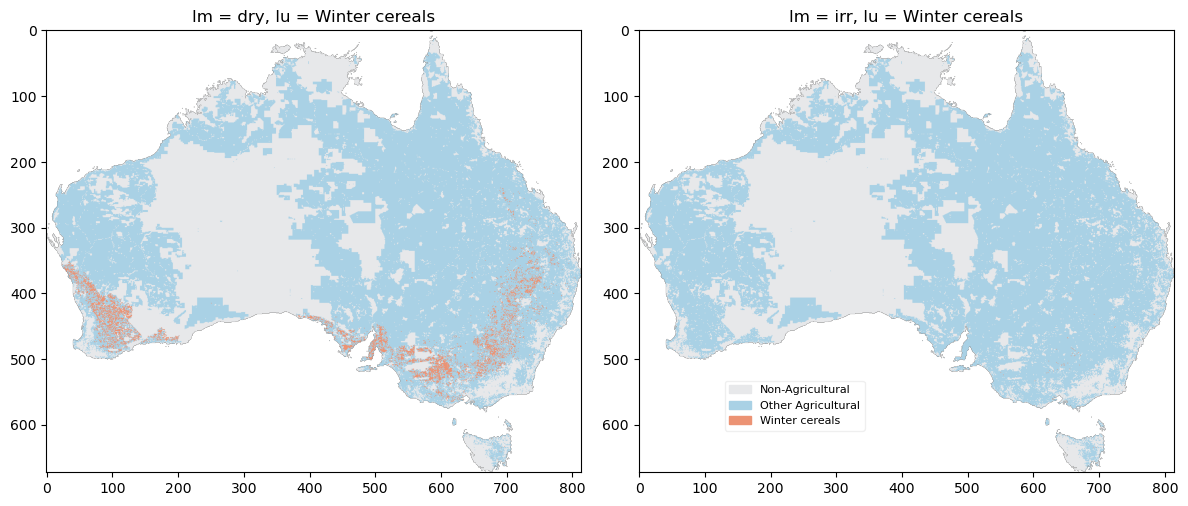

In [7]:
# HIDE CODE

# Get colors/names for pixcels with values of [-1, 0, 1]
colors = [
    (231, 232, 234, 255), # Light grey
    (169, 209, 229, 255), # Light blue
    (236, 147, 116, 255)  # Light red
]

cell_names = [
    'Non-Agricultural', 
    'Other Agricultural', 
    'Winter cereals'
]

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first map (dry) on the first axis
map_to_plot(lu_arr_dry, colors, cell_names, legend_params, ax=axs[0])
axs[0].set_title(f'lm = dry, lu = {lu_desc}')

# Plot the second map (irr) on the second axis
map_to_plot(lu_arr_irr, colors, cell_names, legend_params, ax=axs[1])
axs[1].set_title(f'lm = irr, lu = {lu_desc}')

# Optionally, adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()

Before diving into input data, please keep in mind our objective: find the sptail distribution for winter cereal that is the most cost-minimized/profit-maximized, as well as meeting constraints in water use and GHG emissions.

## Demand

As an agricultural model, the first target to meet is the food demand. The demand data (tones) is a `pandas.DataFrame` lives in the `data.DEMAND_DATA` variable. We can see that the index of the demand dataframe is commodities, the column is a 2-level column that represents demand compositions and years.

```{note}
The demand includes 'DOMESTIC', 'EXPORTS', 'IMPORTS', 'FEED', 'PRODUCTION', where the 'PRODUCTION' record is the demand data that LUTO needs to meet. The relationship between these compositions is:  
`PRODUCTION` = `DOMESTIC` + `EXPORTS` + `FEED` - `IMPORTS`
```

In [249]:
# HIDE CODE
df = data.DEMAND_DATA
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

```{note}
If you have a close look at the `COMMODITY` index, you can find that index items are all lower-case. In addition, there are 32 commodities in total (remember there are only 28 land-uses). Why lower case and 2 more commodities? Carefully observe the table below that shows the mismatched land-use and commodities. Think of the reason by yourself; the answer is in the below explanation.
```

| Land-use                      | Comodity                          |
|-------------------------------|-----------------------------------|
| Beef - modified land          | beef lexp, beef meat              |
| Beef - natural land           | beef lexp, beef meat              |
| Dairy - modified land         | dairy                             |
| Dairy - natural land          | dairy                             |
| Unallocated - modified land   | -                                 |
| Unallocated - natural land    | -                                 |
| Sheep - modified land         | beef lexp, sheep meat, sheep wool |
| Sheep - natural land          | beef lexp, sheep meat, sheep wool |
| -                             | aquaculture                       |
| -                             | chicken                           |
| -                             | eggs                              |
| -                             | pork                              |

The reason for "why 4 more commodities" is that there are 4 commodities (aquculture, chicken, egg, and pork) cannot be produced from any land use. 

The math is simple, but it leads to another problem: If there are 4 additional commodities that cannot be produced by any land use, how can LUTO meet these demands by rearranging land use distributions? The answer is that LUTO assumes the demand for these 4 commodities will be met in the target year, and LUTO only arranges land-use to mitigate their environmental impacts. For example, to meet the demand for eggs in 2030, a total of 500 kt of GHG were emitted. LUTO will then try to plant more trees to sequestrate these carbons. In this way, LUTO considers both on-land (commodities produced directly from land) and off-land (commodities produced from cages or factories) commodities, making itself a more complete agricutural model.

In our case, the winter cereal only comes from `Winter Cereal` land-use, so we just need to inspect the `data.DEMAND_DATA` to get the demand data.

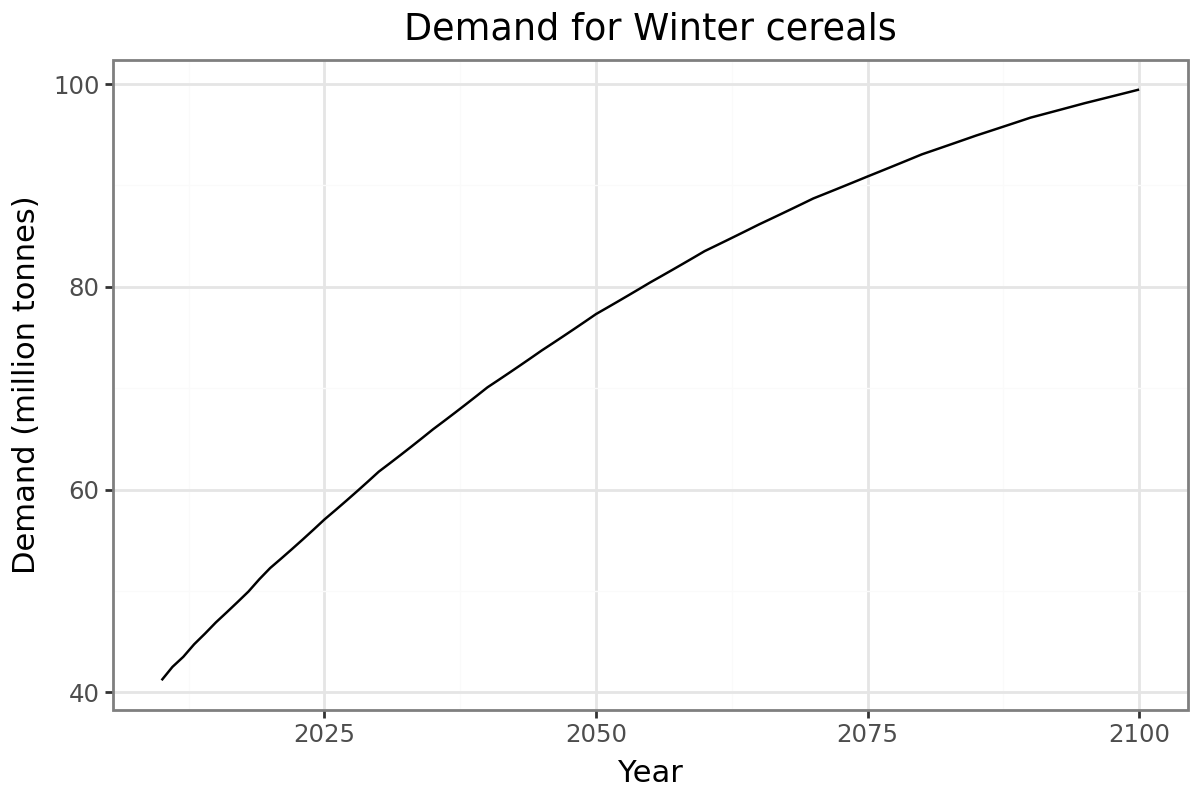

In [356]:
# HIDE CODE
p9.options.figure_size = (6, 4)
p9.options.dpi = 100

# Get the demand data
demand_df = data.DEMAND_DATA.unstack().reset_index()
demand_df.columns = ['Type', 'Year', 'Commodity', 'Value']


# Get the demand for the selected land use
demand_lu = demand_df.query('Type == "PRODUCTION" and Commodity == @lu_desc.lower()')


# Plot the demand
fig = (p9.ggplot(demand_lu, p9.aes(x='Year', y='Value'))
    + p9.geom_line()
    + p9.theme_bw()
    + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
    + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
    )

fig

Let's query the demand data for year 2050 and get the target to meet.

In [209]:
# HIDE CODE
# Get the demand for the target year
demand_vol = demand_lu.query('Year == @year_target')['Value'].values[0] / 1e6  # Million tonnes

print(f'The demand for {lu_desc} in {year_target} is {demand_vol:.2f} million tonnes.')

The demand for Winter cereals in 2050 is 77.31 million tonnes.


::::{important}
Differences in diets, exports, and economic settings will change the demand for food, so it is a good idea to consider these factor's influences on food demand. Luckily, LUTO has provided us with some switches to choose the scenario we are interested. For example, if we want to use the demand with halved food waste, we just need to change the `WASTE` parameter in `luto.settings` to `0.5`.
::::


There are 7 parameters to determine a demand projection, we can change them to fit our anticipation of the future. We can always check the parameters used by printing out `setting.para_name`. This manual uses `SCENARIO=SSP2`, `DIET_DOM='BAU'`, `DIET_GLOB='BAU'`, `CONVERGENCE=2050`, `IMPORT_TREND='Static'`, `WASTE=1`, `FEED_EFFICIENCY='BAU'`. More choices can by found in the below table.         
 

| Parameter         | Values                          | Note                                                                                                                            |
|-------------------|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| SCENARIO          | SSP1, SSP2, SSP3, SSP4, SSP5    |                                                                                                                                 |
| DIET_DOM          | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - domestic diets in Australia                                                                        |
| DIET_GLOB         | BAU, FLX, VEG, VGN              | 'BAU', 'FLX', 'VEG', 'VGN' - global diets                                                                                       |
| CONVERGENCE       | 2050, 2100                      | 2050 or 2100 - date at which dietary transformation is completed (velocity of transformation)                                   |
| IMPORT_TREND      | Static, Trend                   | 'Static' assumes 2010 shares of imports for each commodity or 'Trend' follows historical rate of change in shares of imports    |
| WASTE             | 0.5, 1.0                        | 1 for full waste, 0.5 for half waste                                                                                            |
| FEED_EFFICIENCY   | BAU, High                       | 'BAU' or 'High'                                                                                                                 |



As an illustration, here is the demand for winter cereal under different domestic diets and food waste levels. It shows that socioeconomic settings have significant influences on demand, and food waste level is a much smaller impact factor.

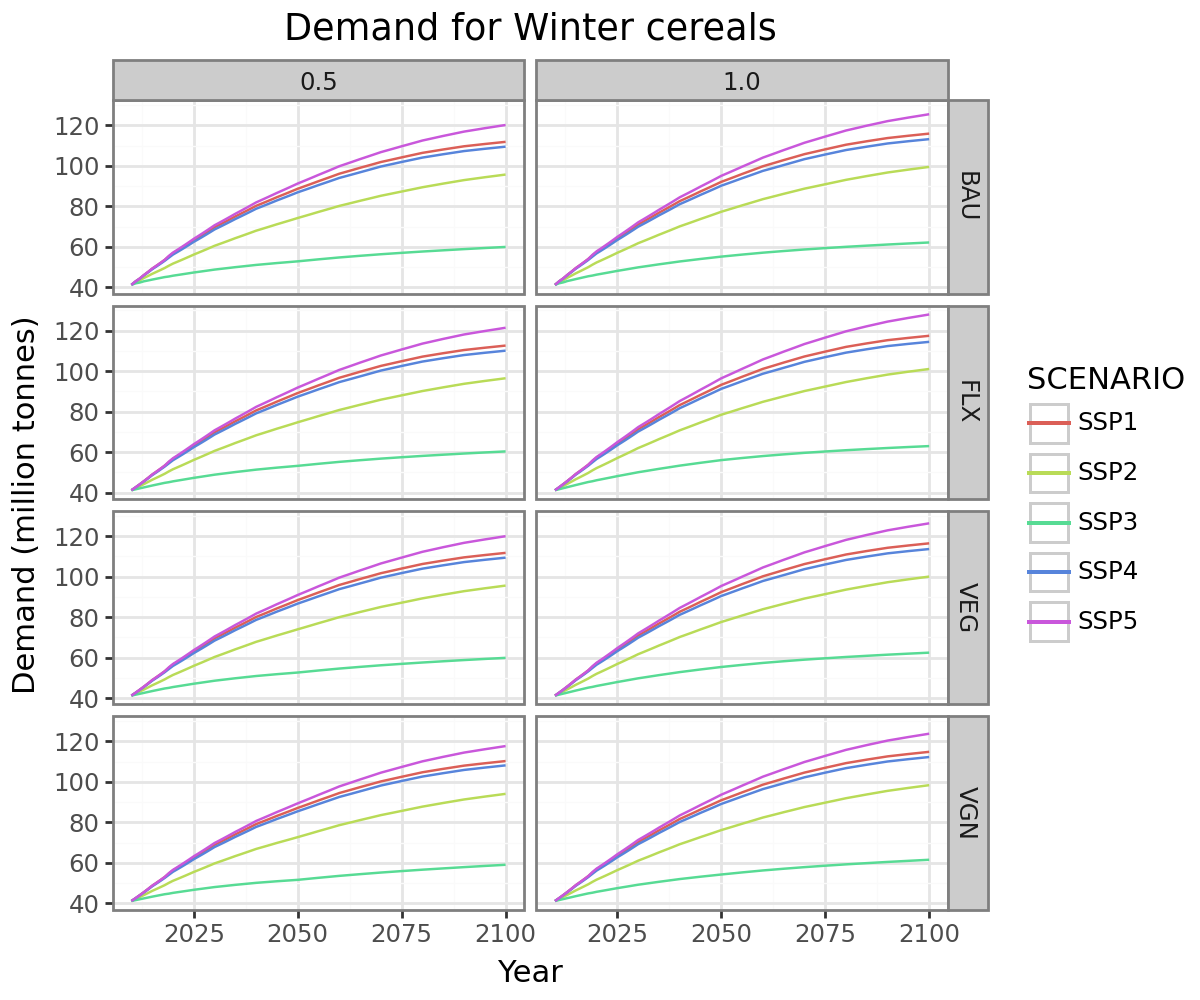

In [354]:
# HIDE CODE


# Get all demand 
dd = pd.read_hdf(os.path.join('input', 'demand_projections.h5') )
dd_long = dd['PRODUCTION'].stack().reset_index().rename(columns={0: 'DEMAND_TONNES'})

# Filter the demand data
commodity = lu_desc.lower()
diet_glob = 'BAU'
conv = 2050
import_t = 'Static'
feed_ef = 'BAU'
d = dd_long.query('COMMODITY == @commodity and DIET_GLOB == @diet_glob and CONVERGENCE == @conv and IMPORT_TREND == @import_t and FEED_EFFICIENCY == @feed_ef')


# Plot the demand under Diet~Waste scenarios
p9.options.figure_size = (6, 5)
p9.options.dpi = 100

fig = (p9.ggplot(d, p9.aes(x='YEAR', y='DEMAND_TONNES', color='SCENARIO'))
     + p9.geom_line()
     + p9.theme_bw()
     + p9.labs(title=f'Demand for {lu_desc}', x='Year', y='Demand (million tonnes)')
     + p9.scale_y_continuous(labels=lambda f: [f'{x / 1e6:.0f}' for x in f])
     + p9.facet_grid('DIET_DOM~WASTE')
    )

fig

OK, now that we know that LUTO needs to produce 77.31 million tonnes of winter cereal in 2050, let's see how it will arrange the spatial distributions to meet this goal.

## Productivity

In LUTO, the productivity is a map where each cell represents the unit production given a land-use. Note the productivities for crop, livestock and dairy are different.
- For crops, each productivity cell represents tonnes/ha
- For livestock, each productivity cell represents heads/ha
- For dairy, each productivity cell represents megalitres/ha

The productivity of crops lives in the `data.AGEC_CROPS` (livestock in the `data.AGEC_LVSTK`) variable as a pd.DataFrame. Both dataframes include cost, revenue, and water requirement data, in addition to productivity records. You can find their abbreviations and full descriptions below: 


The filed `crops` are explained in the below table.
| Abbreviations | Description                           |
|---------|---------------------------------------------|
| AC      | Area cost ($/ha)                            |
| FDC     | Fixed depreciation cost ($/ha)              |
| FLC     | Fixed labour cost ($/ha)                    |
| FOC     | Fixed operating cost ($/ha)                 |
| P1      | Price of output 1 ($/t)                     |
| QC      | Quantity cost ($/t)                         |
| WR      | Water requirement (t/ha)                    |
| WP      | Water price ($/t)                           |
|Yield    | The yield of crop (t/ha)                    |

The column abbreviations and their meanings for `livestock` are explained in the below table.

| Abbreviations | Description                                      |
|---------|--------------------------------------------------|
| F1      | Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> or <milk for `DAIRY`> |
| F2      | Fraction of herd to produce `WOOL` for `SHEEP`  |
| F3      | Fraction of herd as `Live export` for `BEEF` and `SHEEP` |
| Q1      | Quantity of output 1 (tonnes/head)              |
| Q2      | Quantity of output 2 (tonnes/head)              |
| Q3      | Quantity of output 3 (animal weight tonnes/head) |
| P1      | Price of output 1 ($/t)                         |
| P2      | Price of output 2 ($/t)                         |
| P3      | Price of output 3 ($/t)                         |
| WR_DRN  | Water requirement (t/head)                       |
| WR_IRR  | Water requirement (t/ha) (applies to `irr` livestock) |


Observing the economic data for crops, we can see the index is `CELL_ID`, and the column has 3 levels (from top to bottom, each level indicates data type, water supply, and land use). 

In [247]:
# HIDE CODE


df = data.AGEC_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled


However, the economic data for livestock does not have water supply infomation in the column. Why is that? We can see that the `data.AGEC_LVSTK` only includes yield of dryland animals. In LUTO, we multiply the dryland productivety by a factor of 2 when to get irrigated land productivity. See [here](https://github.com/JinzhuWANG/luto-2.0/blob/dbe1fcfdf57075867a6f46de76dd6d0f872fa105/luto/economics/agricultural/quantity.py#L131) for the detailed implementation.

In [248]:
# HIDE CODE
df = data.AGEC_LVSTK.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

df_styled

,F1,Q1,P1,AC,QC,FOC,FLC,FDC,WR_DRN,WR_IRR,F1,F3,Q1,Q3,P1,P3,AC,QC,FOC,FLC,FDC,WR_DRN,WR_IRR,F1,F2,F3,Q1,Q2,Q3,P1,P2,P3,AC,QC,FOC,FLC,FDC,WR_DRN,WR_IRR
,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,DAIRY,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,BEEF,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP,SHEEP
273,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
335,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
515,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
520,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
614,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
694,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
699,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
777,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
782,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


```{note}
Do you notice that the `CELL_ID` is not continuing, and there are a lot of `NaN` values in the dataframe? The discontinuity `CELL_ID` is due to data masking, and the None value comes from the exclusion masking. Essentialy, the data masking means we have removed some cells that will never be used in the analysis (e.g., cells cover sea, water, and intensive land-use like urban), and the None value indicates that the coresponding land-use can't exist in this cell. Let's plot the productivity data (`yield` record for crops, `P1/2/3` for livestock), have a visual on it, and then explain the data masking and exclusion masking.
```


In [91]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agec_crops_xr = []
for col in data.AGEC_CROPS.columns:
    series = data.AGEC_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agec_crops_xr.append(series_xr)

# Combine the xarray objects
agec_crops_xr = xr.combine_by_coords(agec_crops_xr)

# Get the data for the given land-use
agec_crops_xr_lu = agec_crops_xr.sel(lu=lu_desc)

In [176]:
# REMOVE

# Helper function to plot the quantity matrices
def plot_dry_irr(dry_irr, irr_arr):

    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

    # Plot the maps side by side
    dry_irr.plot(vmin=dry_irr.min(), vmax=dry_irr.max(), ax=axs[0])
    irr_arr.plot(vmin=irr_arr.min(), vmax=irr_arr.max(), ax=axs[1])

    # Optionally, adjust the layout
    plt.tight_layout()

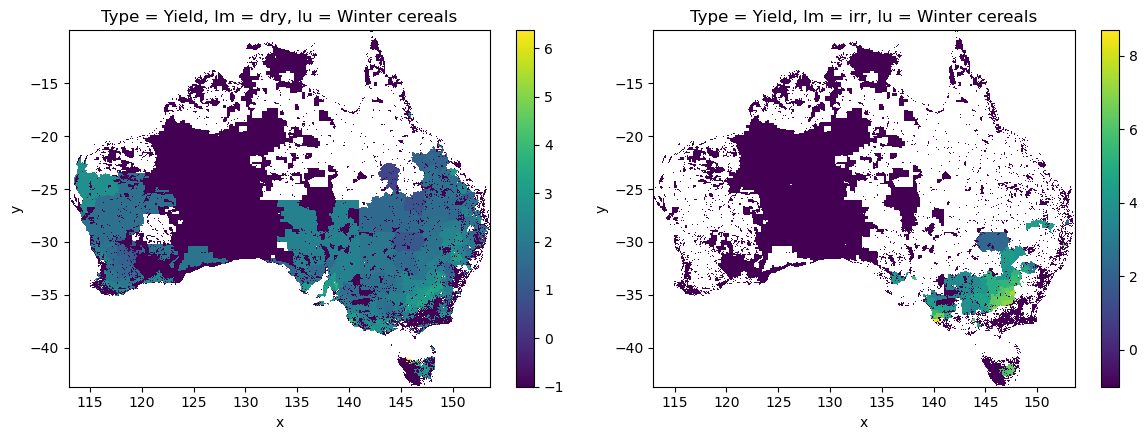

In [117]:
# HIDE CODE

# Get the yield for the given land-use
p_dry = agec_crops_xr_lu.sel(Type='Yield', lm='dry').drop_vars('spatial_ref')
p_irr = agec_crops_xr_lu.sel(Type='Yield', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(p_dry, p_irr)

As discussed before, the productivity data need to be divided by water supply attribution (dry or irrigated). In addition, we can see there are 4 types of cells in the map: 
- white (or transparent) cells outside the continental Australia,  
- white (or transparent) cells inside the continental Australia, 
- dark purple cells (with -1 value) covers the non-agricultural land-use (water, desert, urban, etc.).
- colorful cells with values >= 0 and convey physical information (yield in this case).

Now let's discuss why we need data masking. A fact about these 2D maps is that even though we only care about the yield data, the computer still needs to store the white (transparent) cells! A glance at these maps could give us a quick estimate that more than half of the map's space was used to store meaningless information; that's not a good idea, and LUTO indeed has a way to deal with this waste. Below are the steps for LUTO to remove unnecessary data/cells. 

First, LUTO will drop the cells that cover the sea (outside continental Australia) using a national land-use mask (plotted below).

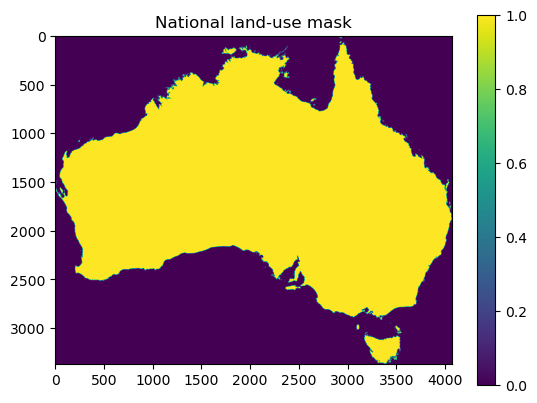

In [108]:
# HIDE CODE
plt.imshow(data.NLUM_MASK)
plt.colorbar()
plt.title('National land-use mask')
plt.show()

Next, LUTO uses a 'Land-use mask' to remove the non-agricultural land-use (e.g., water, desert, urban, etc.) 

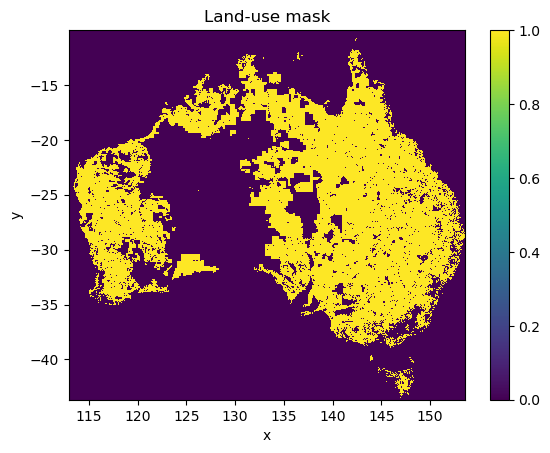

In [134]:
# HIDE CODE
lu_mask.plot()
plt.title('Land-use mask')
plt.show()

The 'National land-use mask' and 'Land-use mask' apply to all input data, but the exclusion mask is created separately for each land-use. In our case, the exclusion mask is a map indicating where is **suitable** and where is **not suitable** for caltivating winter cereal. LUTO uses a simple method to determine suitability for winter cereal: out of every [SA2](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/statistical-area-level-2) region, if this region had winter cereal in 2010, then the whole region would be suitable for winter cereal planting; otherwise, this region would be excluded from planting winter cereal in the future. In this manual, we will sum up all winter cereal cells in each SA2 region and make a plot to visulize this idea.

In [169]:
# REMOVE

sa2 = gpd.read_file('luto/tools/Manual_jupyter_books/asset/sa2_2011_aus/SA2_2011_AUST_continental_simplified.shp')

# Get the sum of pixels for each SA2 region
lu_dry_bool = np.where(lu_arr_dry.values == 1, 1, 0)
lu_irr_bool = np.where(lu_arr_irr.values == 1, 1, 0)

lu_dry_sa2_sum = zonal_stats(sa2, lu_dry_bool, affine=lu_arr_dry.rio.transform(), nodata=0, stats='sum')
lu_irr_sa2_sum = zonal_stats(sa2, lu_irr_bool, affine=lu_arr_irr.rio.transform(), nodata=0, stats='sum')

sa2['dry_count'] = [x['sum'] for x in lu_dry_sa2_sum]
sa2['irr_count'] = [x['sum'] for x in lu_irr_sa2_sum]


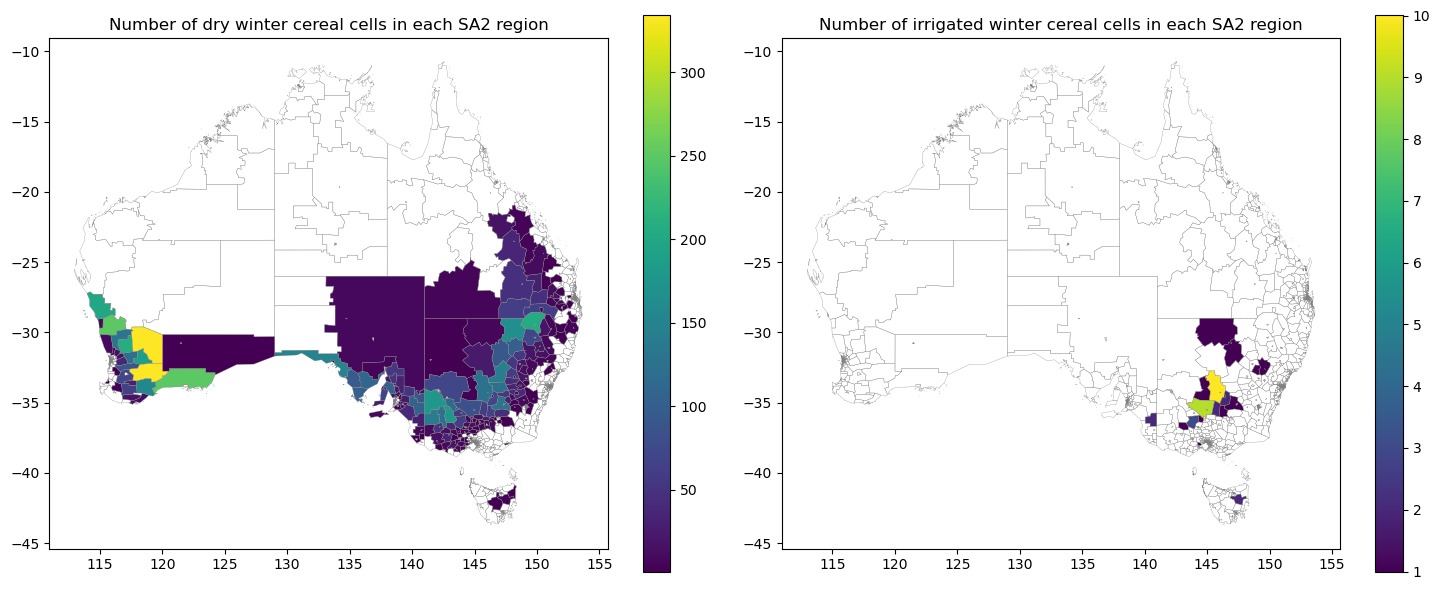

In [223]:
# HIDE CODE
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for dry_count
sa2.plot(ax=ax[0], column='dry_count', legend=True)
sa2.plot(ax=ax[0], color='none', edgecolor='grey', linewidth=0.2)
ax[0].set_title('Number of dry winter cereal cells in each SA2 region')

# Plot for irr_count
sa2.plot(ax=ax[1], column='irr_count', legend=True)
sa2.plot(ax=ax[1], color='none', edgecolor='grey', linewidth=0.2)
ax[1].set_title('Number of irrigated winter cereal cells in each SA2 region')

plt.tight_layout()
plt.show()

Now the last piece for productivity is completed! If you look at the above exclusion masks and compare them with the yield map of winter cereal, you will find that yield data only exist in the'suitable SA2 regions', which is a way to avoid its plantation outside the suitable zones.

```{warning}
We noticed that some SA2 regions have only a few winter cereal plantations but cover a large area that is not suitable for winter cereal's cultivation. This is a known issue in LUTO and will be fixed in the near future.
```

OK, we have yield for winter cereal, but something is still missing. The yield map only represents the productivity for 2010, and we want to get the yield for the whole 2010–2100 period. Because crop productivity is primarily determined by climate change, we will use it as a proxy to extend yield from 2010 to 2100.

## Climate change impacts

We used the `attainable yield` data from [GAEZ](https://gaez.fao.org/) to calculate climate change's impact on crop yield. Attainable yield is the maximum yield under optimal management practices and without the limitations of water, nutrients, pests, or diseases, but within the constraints of local climate and soil conditions. It is safe to say that attainable yield is directly related to climate change, and that's why we (and many other studies) use it to quantify climate change's influences on crops. 

```{note}
GAEZ attainable yield includes several climate models (CRUTS32, GFDL-ESM2M, HadGEM2-ES, IPSL-CM5A-LR, MIROC-ESM-CHEM, NorESM1-M). In LUTO, we used the mean value across all models as the input attainable yield. Climate change is also predicted to have different paths. LUTO has a `settings.RCP` (one of rcp2p6, rcp4p5, rcp6p0, and rcp8p5) to specify the climate change scenarios. Note that this scenario setting is shared among many input data (demand, biodiversity, water use, etc.). In addition to RCP, the assumption on CO2 fertilization effect also has significant impacts on attainable yield, and LUTO has a `settings.CO2_FERT` ('on' or 'off') for us to choose if we want to include this effect. 
```

In [11]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
cci_crops_xr = []
for col in data.CLIMATE_CHANGE_IMPACT.columns:
    series = data.CLIMATE_CHANGE_IMPACT[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'lm': [col[0]], 
        'lu': [col[1]], 
        'year': [col[2]]
    })
    cci_crops_xr.append(series_xr)

# Combine the xarray objects
cci_crops_xr = xr.combine_by_coords(cci_crops_xr)


# Append ones as the climate change impact in year 2010
cci_ones_dry = cci_crops_xr.sel(lm=['dry'], year=[2020])
cci_ones_dry.data = np.ones_like(cci_ones_dry.data)
cci_ones_dry.coords['year'] = [2010]
cci_ones_irr = cci_crops_xr.sel(lm=['irr'], year=[2020])
cci_ones_irr.data = np.ones_like(cci_ones_irr.data)
cci_ones_irr.coords['year'] = [2010]
cci_crops_xr = xr.combine_by_coords([cci_crops_xr, cci_ones_dry, cci_ones_irr])


# Get the data for the given land-use
cci_crops_xr_lu = cci_crops_xr.sel(lu=lu_desc)
# Linearly interpolate the data to 2010-2100
cci_crops_xr_lu = cci_crops_xr_lu.interp(year=range(2010, 2101), method='linear', kwargs={"fill_value": "extrapolate"})

In this manual, we chose the `settings.rcp == 'rcp4p5'` scenario and plotted the climate impact below. From it, we can see that climate change impact is introduced as a multiplier to crop yield. The climate change in 2050 is mostly positive for winter cereal. Also, note that this impact multiplier only exists in the'suitable zones', which means that we have intentionally excluded winter cereal from cultivating in unsuitable areas.

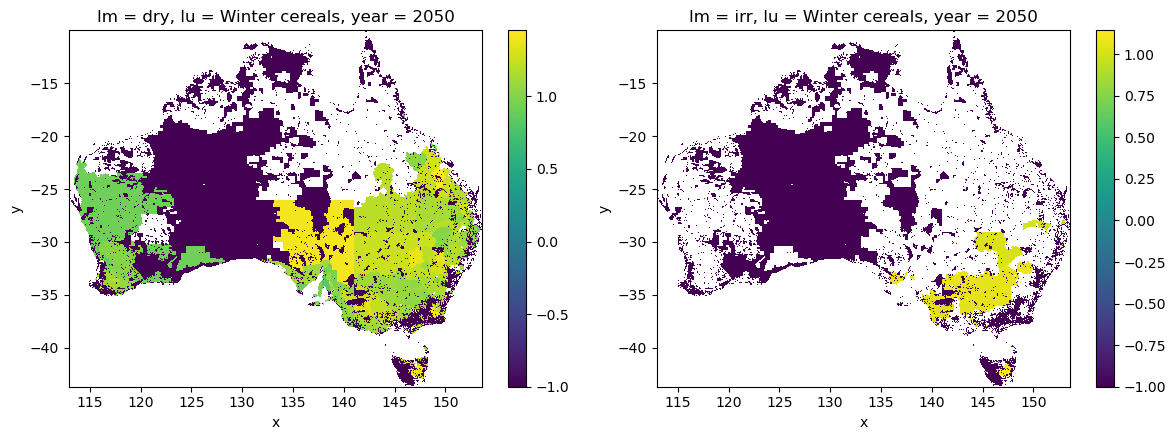

In [12]:
# HIDE CODE

# Get the data for the given year
cci_dry = cci_crops_xr_lu.sel(lm='dry', year=year_target).drop_vars('spatial_ref')
cci_irr = cci_crops_xr_lu.sel(lm='irr', year=year_target).drop_vars('spatial_ref')

plot_dry_irr(cci_dry, cci_irr)

In [149]:
# REMOVE


# Functiont to read the climate change impact data and convert it to xarray
def read_cc_impact(rcp, co2, lu=lu_desc):
    df = pd.read_hdf(os.path.join('input', "climate_change_impacts_" + rcp + "_CO2_FERT_" + co2 + ".h5")).iloc[data.MASK]
    df = df.loc[:, (slice(None), lu_desc, slice(None))]
    df = df.unstack().reset_index().rename(columns={'level_0': 'water_supply', 'level_1': 'Land-use', 'level_2': 'Year', 0: 'Value'})
    
    # Convert the data to xarray
    df_xr = []
    for col, df_ in df.groupby(['water_supply', 'Land-use', 'Year']):
        arr_xr = arr_to_xr(data, df_['Value']).expand_dims({
            'lm': [col[0]],
            'lu': [col[1]],
            'year': [col[2]]
        })
        df_xr.append(arr_xr)
    df_xr = xr.combine_by_coords(df_xr)

    # Append ones as the climate change impact in year 2010
    ones_xr = df_xr.sel(year=[2020]) / df_xr.sel(year=[2020])
    ones_xr.coords['year'] = [2010]
    df_xr = xr.combine_by_coords([df_xr, ones_xr])

    # Interpolate the data to 2010-2100
    df_xr = df_xr.interp(year=list(df_xr['year'].values) + [2100], method='linear', kwargs={"fill_value": "extrapolate"})
    
    # Add rcp and co2_fert as coordinates
    df_xr = df_xr.expand_dims({'rcp': [rcp], 'co2_fert': [co2]})
        
    return df_xr

In [151]:
# REMOVE

# Read the climate change impact data
rcps = ['rcp2p6', 'rcp4p5', 'rcp6p0', 'rcp8p5']
co2_fert = ['on', 'off']

cc_impacts = []
for rcp,co2 in tqdm(product(rcps, co2_fert)):
    arr = read_cc_impact(rcp, co2)
    cc_impacts.append(arr)
    
cc_impacts = xr.combine_by_coords(cc_impacts)

0it [00:00, ?it/s]

If you are curious about climate change's impact under different `RCP` and `CO2 Fertilization` effects, we have prepared a plot to illustrate the mean value of all climate change multipliers below. We can see that winter cereal's yields under dry and irrigated water supplies are significantly different. Also note the opposite trend of yield trajectory prediction under different CO2 fertilization effects. It is clear that we have to be very careful when choosing the right RCP and CO2_fert parameters in LUTO because different assumptions will lead to very different agricultural productivity in the future!

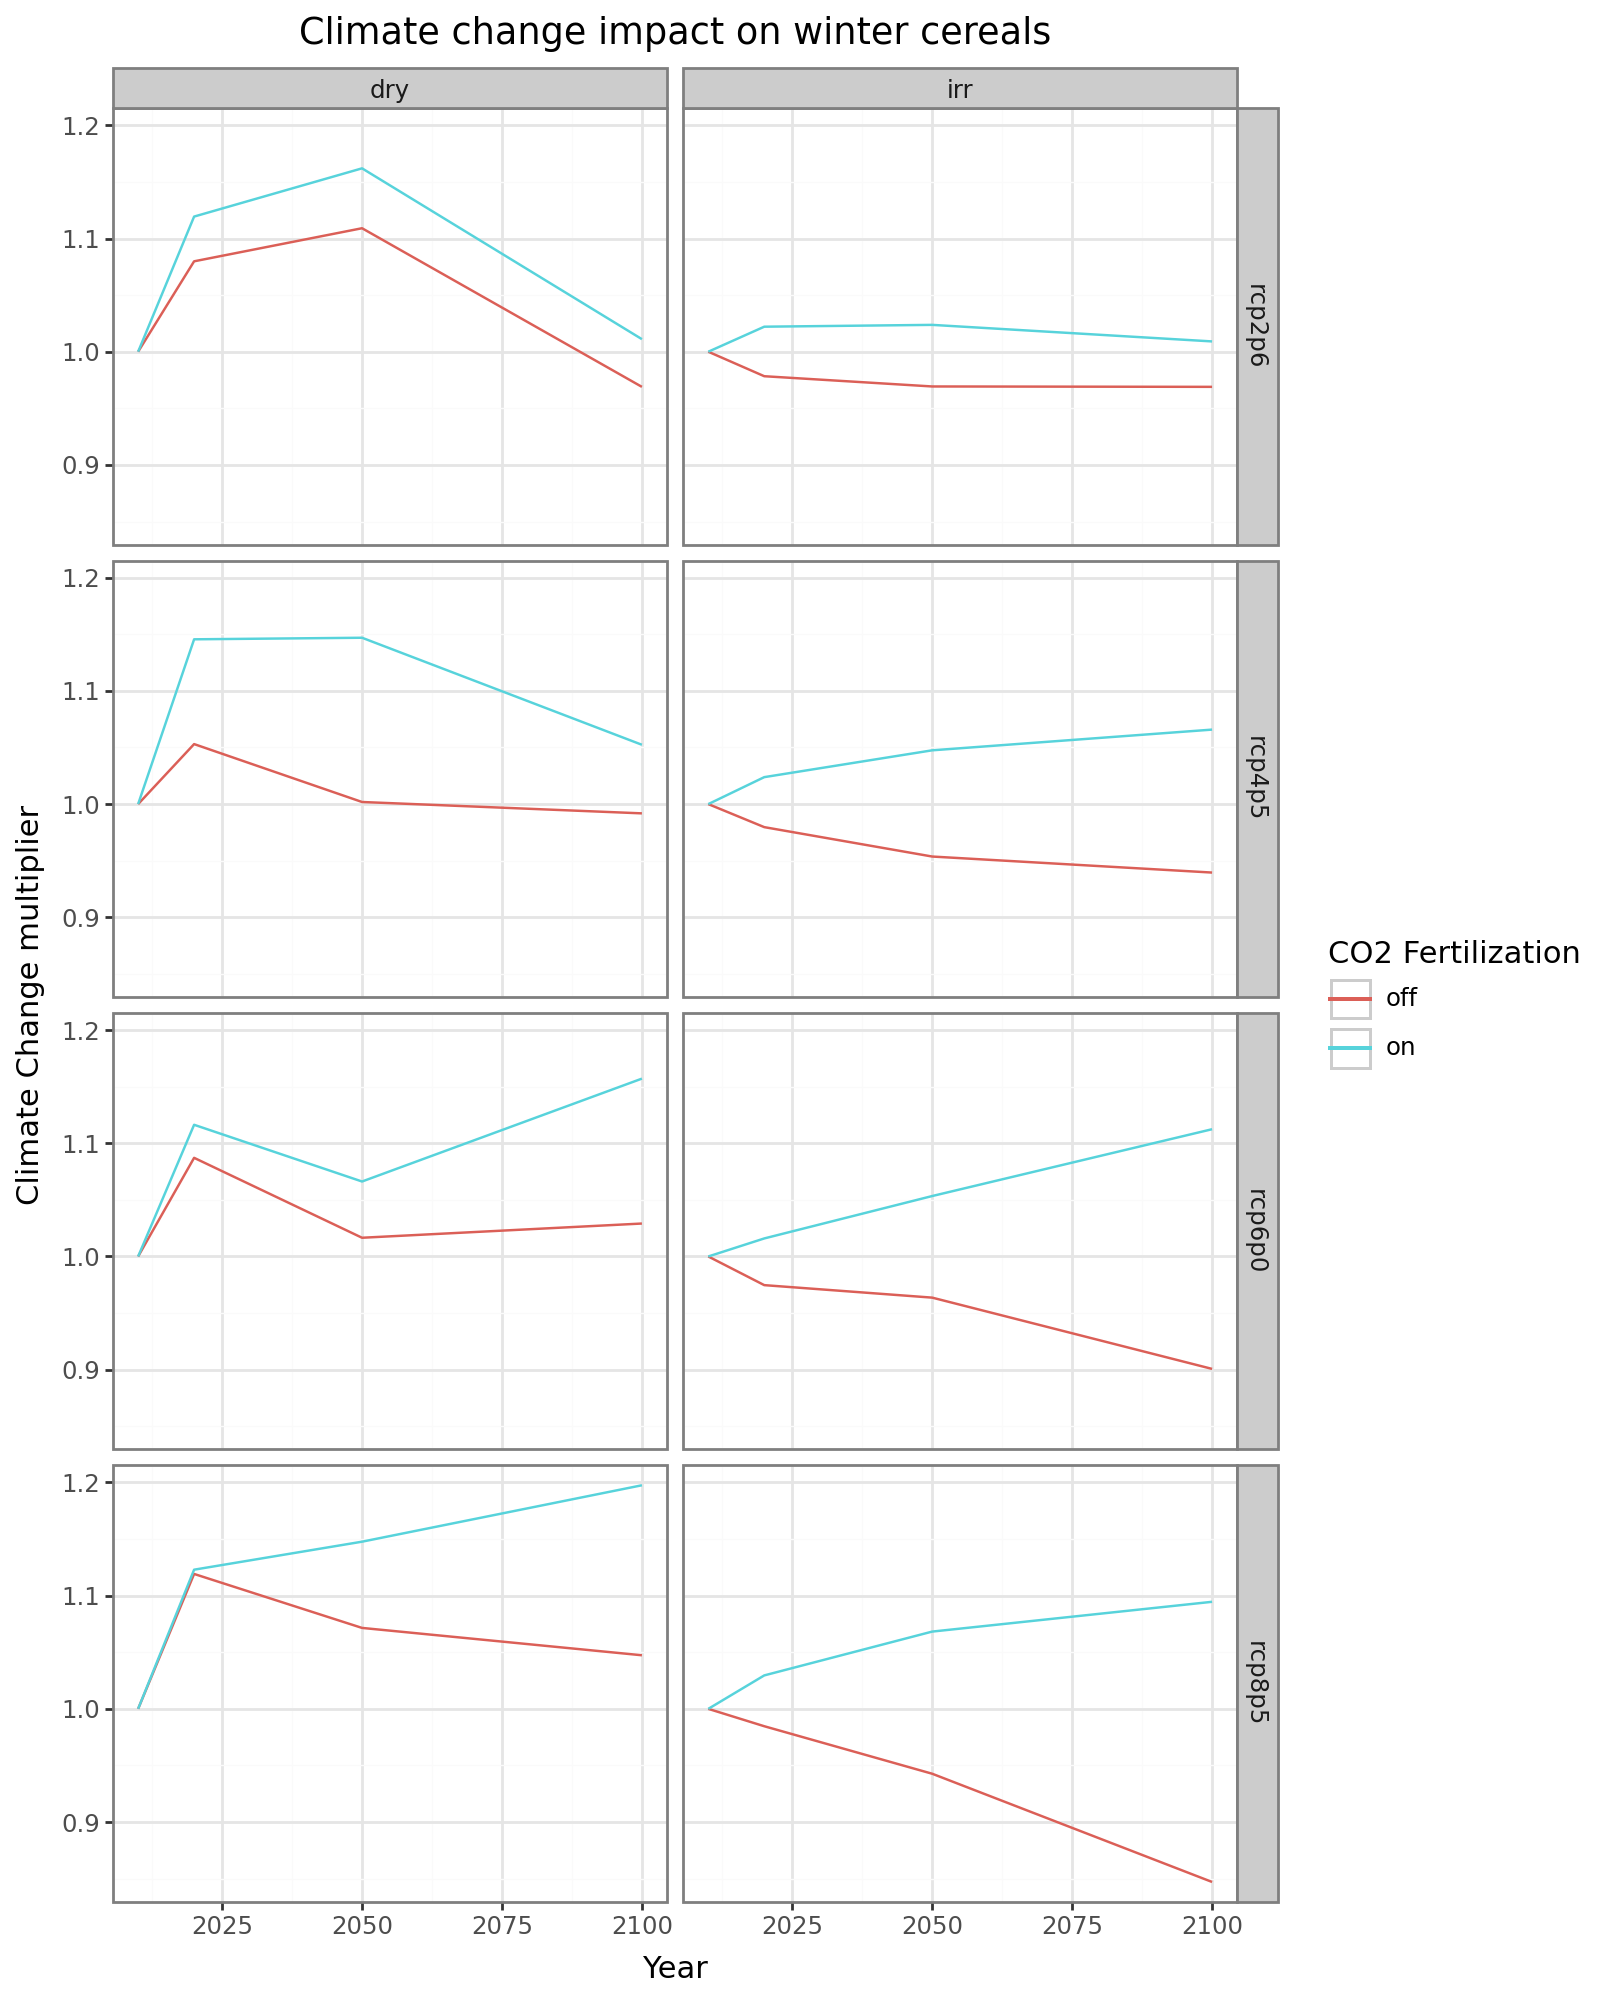

In [174]:
# HIDE CODE

cc_impacts_lu = cc_impacts * lu_mask.where(lu_mask == 1)
cc_impacts_lu_stats = cc_impacts_lu.mean(dim=['x', 'y']).to_dataframe(name='cc_multiplier').reset_index()

(p9.ggplot(cc_impacts_lu_stats)
     + p9.geom_line(p9.aes(x='year', y='cc_multiplier', color='co2_fert'))
     + p9.facet_grid('rcp ~ lm')
     + p9.theme_bw()
     + p9.labs(title='Climate change impact on winter cereals', x='Year', y='Climate Change multiplier', color='CO2 Fertilization')
)

## Commodity production 

Now we can extend winter cereal's yield to 2050 by multiplying its yield in 2010 with climate change's impact in 2050 (in the below map).

In [181]:
# REMOVE
yr_idx = year_target - year_begin
# Get the quantity matrices
q_mrp = get_quantity_matrices(data, yr_idx).astype(np.float32)          # t/cell
q_mrp_xr = mrj_to_xr(data, q_mrp).expand_dims({'year': [year_target]})  

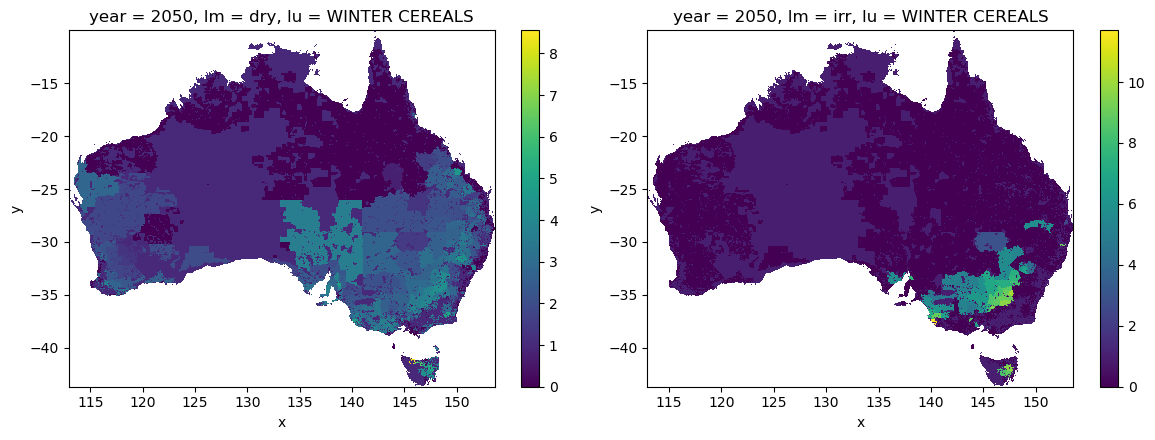

In [221]:
# HIDE CODE
q_lu_target = q_mrp_xr / lu_area  # t/ha

q_dry_target = q_lu_target.sel(lm='dry', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
q_irr_target = q_lu_target.sel(lm='irr', lu=lu_desc.upper(), year=year_target).drop_vars('spatial_ref')
plot_dry_irr(q_dry_target, q_irr_target)

Let's use winter cereal's spatial distribution in 2010 and its yield of 2050 to get the production in 2050. If the result is larger than demand, that means we do not need to do anything to winter cereal; otherwise, we need to rearrange its spatial distribution to meet the demand of 2050.

```{note}
To get the production, we simply need to apply below function: `production` = `land-use map` * `yield map`. However, there are a few things need to keep in mind:
- The `land-use map` is just a spatial indication of how the land is used. It does not have any physical meaning attached.
- `yield map` is a physical indication of 'tonnes/hactor'
- We need to assign the `area (hactor)/cell` information to land-use map so that the result will be a production (`tonnes/cell`)
```


LUTO has a `data.REAL_AREA` variable that stores the true area (hactor) for each cell. In order to get winter cereal's production, we need to include this data in the formulation `production (tonne/ha)` = `land-use map` * `area map (ha/cell)` * `yield map (tonne/ha)` for a correct calculation. Have a think about why the area in the north part is larger than the south (LUTO uses the 'Geocentric Datum of Australia (GDA) 1994 coordinate system).

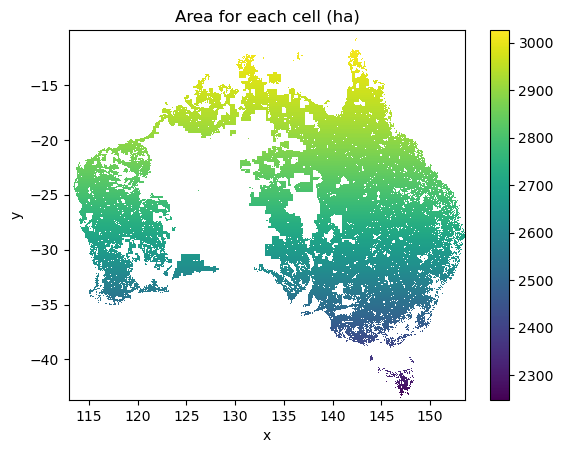

In [348]:
# HIDE CODE
lu_area.where(lu_mask == 1).plot()
plt.title('Area for each cell (ha)')
plt.show()

In [202]:
# HIDE CODE

# Calculate the total quantity for each water supply
q_dry_total = lu_arr_dry.values * lu_area.values * q_dry_target.values * lu_mask.values      
q_dry_total = np.nansum(q_dry_total) / 1e6          # million t               

q_irr_total = lu_arr_irr.values * lu_area.values * q_irr_target.values * lu_mask.values   
q_irr_total = np.nansum(q_irr_total) / 1e6          # million t 

# Get the total quantity for the given land-use
q_total = q_dry_total + q_irr_total                 # million t       

print(f'Total quantity for {lu_desc} in {year_target}: {q_total:.2f} million tonnes.') 

Total quantity for Winter cereals in 2050: 51.00 million tonnes.


Recall that the demand for winter cereal will be 77.31 million tonness in 2050 and there will be a 26.31 million metric tons shortage based on winter cereal's 2010 spatial distribution. Therefore, we need to increase winter cereal's plantation to fill this gap.

To make it simple, let's gradually close the demand gap by randomly adding cells to the winter cereal's map of 2010:
1) Randomly selected 10 cells to both dry and irrigated winter cereal map for 2010
2) Reduce the demand gap by subtracting the production from these 10 newly added cells
3) If the demand was closed, then stop this random cell addition
4) If the demand still exist, then start another round of random cell addition

```{note}
In this example, we use the random cell addition method to simplify the process of finding a solution. In LUTO, we utilize a commercial solver called [Gurobi](https://www.gurobi.com/) to find the optimal solution. The detailed implementation can be found [here](https://github.com/land-use-trade-offs/luto-2.0/blob/master/luto/solvers/solver.py).
```

In [223]:
# REMOVE

# Get the available land for the given land-use
lu_arr_dry_aval = (lu_arr_dry == 0) * (lu_arr_irr != 1) * (q_dry_target > 0)
lu_arr_irr_aval = (lu_arr_irr == 0) * (lu_arr_dry != 1) * (q_irr_target > 0)

In [274]:
# REMOVE

def rand_reduce_gap(in_dry, in_irr, q_dry, q_irr, gap, chunk_size=10):

    # Get the row/col for the non-zero values
    row_dry, col_dry = np.nonzero(in_dry)
    row_irr, col_irr = np.nonzero(in_irr)

    # Get the index for the non-zero values
    idx_dry = list(range(len(row_dry)))
    idx_irr = list(range(len(row_irr)))
    
    # Initialize the selected index
    sel_idx_dry = []
    sel_idx_irr = []
    
    # Loop until the gap is closed
    while gap>= 0:
        if len(idx_dry) <= chunk_size or len(idx_irr) <= chunk_size:
            print('Not enought land for the meeting the production gap.')
            break
        
        sel_dry = np.random.choice(idx_dry, chunk_size, replace=False)
        sel_irr = np.random.choice(idx_irr, chunk_size, replace=False)
        
        [idx_dry.remove(i) for i in sel_dry]
        [idx_irr.remove(i) for i in sel_irr]
        
        sel_idx_dry.extend(sel_dry)
        sel_idx_irr.extend(sel_irr)
        
        gap -= np.nansum(q_dry.values[row_dry.values[sel_dry], col_dry.values[sel_dry]])
        gap -= np.nansum(q_irr.values[row_irr.values[sel_irr], col_irr.values[sel_irr]])
        
    # Get the pred array
    pred_arr_dry = lu_arr_dry.copy()
    pred_arr_irr = lu_arr_irr.copy()
    
    pred_arr_dry.values[row_dry.values[sel_idx_dry], col_dry.values[sel_idx_dry]] = 2
    pred_arr_irr.values[row_irr.values[sel_idx_irr], col_irr.values[sel_idx_irr]] = 2
           
    return pred_arr_dry, pred_arr_irr

In [275]:
# REMOVE

# Randomly select from available land to meet the production gap
from joblib import Parallel, delayed 
from tqdm.auto import tqdm  

n_runs = 100     

gap = (demand_vol - q_total) * 1e6              # tonnes
q_dry_cell = q_dry_target * lu_area             # t/cell
q_irr_cell = q_irr_target * lu_area             # t/cell

para_obj = Parallel(n_jobs=20, return_as='generator')
tasks = (delayed(rand_reduce_gap)(lu_arr_dry_aval, lu_arr_irr_aval, q_dry_cell, q_irr_cell, gap, chunk_size=10) for _ in range(n_runs))
results = [i for i in tqdm(para_obj(tasks), total=n_runs)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [277]:
# REMOVE

# Combine all results to one xarray object
pred_arr_xr = []
for i,arr in enumerate(results):
    dry_arr = arr[0].expand_dims({'run': [i], 'lm':['dry']},)
    irr_arr = arr[1].expand_dims({'run': [i], 'lm':['irr']},)
    pred_arr_xr.append(dry_arr)
    pred_arr_xr.append(irr_arr)

# Combine the xarray objects
pred_arr_xr = xr.combine_by_coords(pred_arr_xr)   

Here, we repeat the random process 100 times so that we can illustrate how LUTO finds the best solution under various constraints and objective functions. Below are the simulated results stored in a `xarray.DataArray`, we can see that `run: 100` indicates there are 100 runs, `lm: 2` means each run includes a dry and an irrigated result, and `x` and `y` are the height and weight of each result.

In [297]:
# HIDE CODE
pred_arr_xr['data']

<xarray.DataArray 'data' (run: 100, lm: 2, y: 673, x: 814)> Size: 438MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * run          (run) int32 400B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * lm           (lm) object 16B 'dry' 'irr'
    lu           <U14 56B 'Winter cereals'
  * x            (x) float64 7kB 113.0 113.0 113.0 113.1 ... 153.5 153.6 153.6
  * y            (y) float64 5kB -10.04 -10.09 -10.14 ... -43.54 -43.59 -43.64
    spatial_ref  int32 4B 0

Let's plot the first solution (run = 0) and compare it with the original land-use map. We can see the randomly added pixel of dryland winter cereal scattered across south Australia, and the irrigated winter cereal is more closely aggregated around in the sourtheast. Remember, this is just one solution out of the 100 runs. The question is: how do you find the best one? The general idea is that we will calculate the water consumption, GHG emissions, and biodiversity contribution to exclude solutions we can't accept, and finally use revenue/cost to get the solution with the minimized cost or maximized profit. 

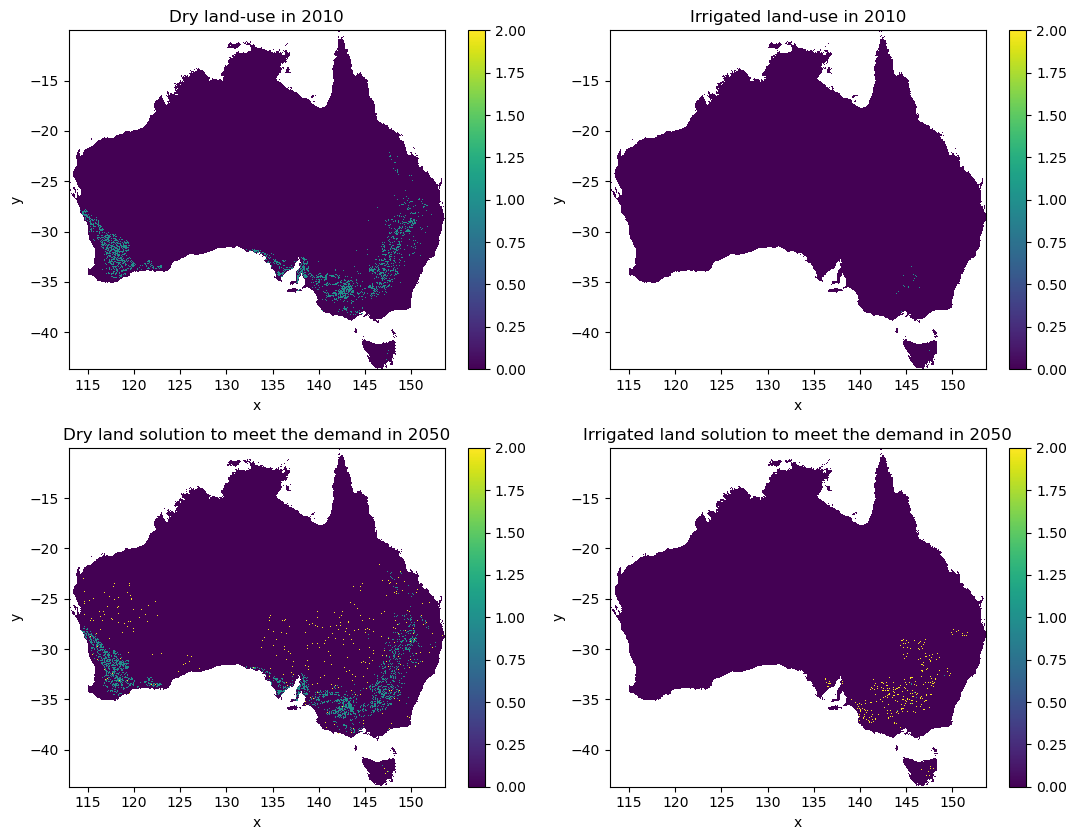

In [359]:
# HIDE CODE

fig, axs = plt.subplots(2,2, figsize=(11, 8.5), dpi=100)
axs = np.array(axs).flatten()

(lu_arr_dry * lu_mask).plot(ax=axs[0], vmax=2)
axs[0].set_title('Dry land-use in 2010')

(lu_arr_irr * lu_mask).plot(ax=axs[1], vmax=2)
axs[1].set_title('Irrigated land-use in 2010')

(pred_arr_xr['data'].sel(lm='dry', run=0) * lu_mask).plot(ax=axs[2])
axs[2].set_title('Dry land solution to meet the demand in 2050')

(pred_arr_xr['data'].sel(lm='irr', run=0) * lu_mask).plot(ax=axs[3])
axs[3].set_title('Irrigated land solution to meet the demand in 2050')

plt.tight_layout()


## Water Requirement

In [55]:
# REMOVE
wr_mrj = get_wreq_matrices(data, year_target - year_begin)              # ML/cell
wr_mrj_xr = mrj_to_xr(data, wr_mrj) / lu_area * lu_mask                 # ML/ha

wr_mrj_xr_lu = wr_mrj_xr.sel(lu=lu_desc)

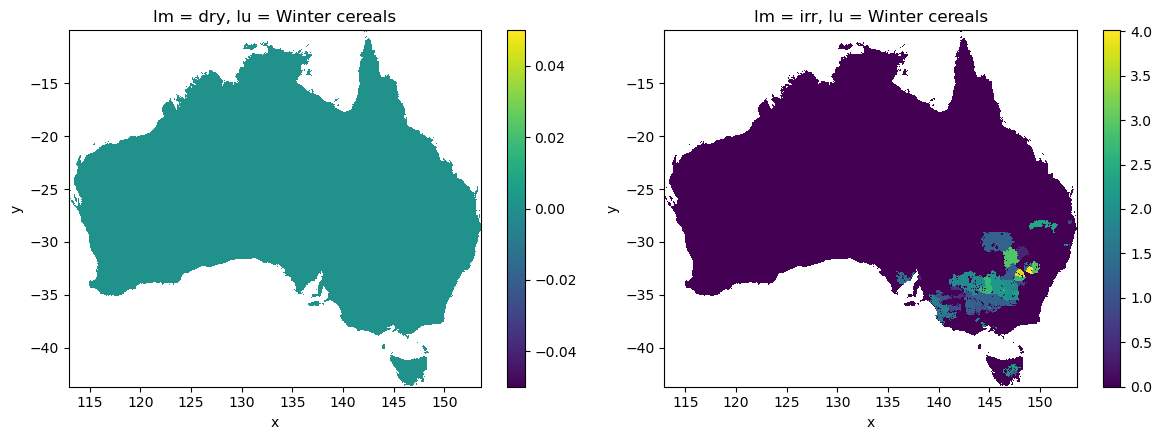

In [ ]:
# HIDE CODE
wr_dry = wr_mrj_xr_lu.sel(lm='dry').drop_vars('spatial_ref')
wr_irr = wr_mrj_xr_lu.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(wr_dry, wr_irr)

## Costs and Revenues

In [ ]:
# REMOVE

# Area Cost, Fixed Depreciation Cost, Fixed Labour Cost, Fixed Operating Cost   
c_fix = agec_crops_xr_lu.sel(Type=['AC', 'FDC', 'FLC', 'FOC'])       # $/ha

# Quantity Cost
c_q = agec_crops_xr_lu.sel(Type='QC') * q_lu_target                  # $/ha

# Water Cost
c_wr = agec_crops_xr_lu.sel(Type='WP') * wr_mrj_xr_lu                # $/ha          

# Revenue
r = agec_crops_xr_lu.sel(Type='P1') * q_lu_target                    # $/ha   


###########    Total Cost    ###########
c_total = c_fix.sum(dim='Type') + c_q + c_wr                         # $/ha  

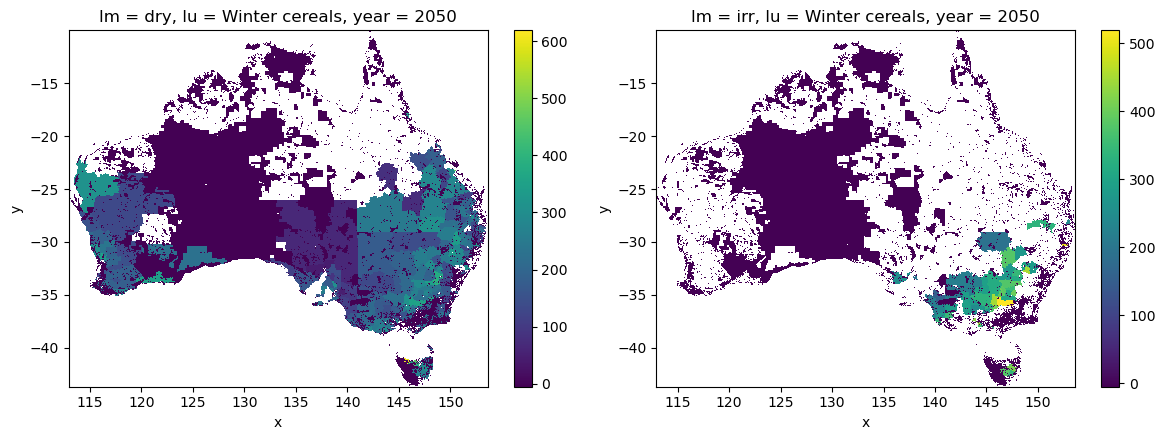

In [ ]:
# HIDE CODE

c_arr = c_total

# REMOVE
c_dry = c_arr.sel(lm='dry').drop_vars('spatial_ref')
c_irr = c_arr.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(c_dry, c_irr)

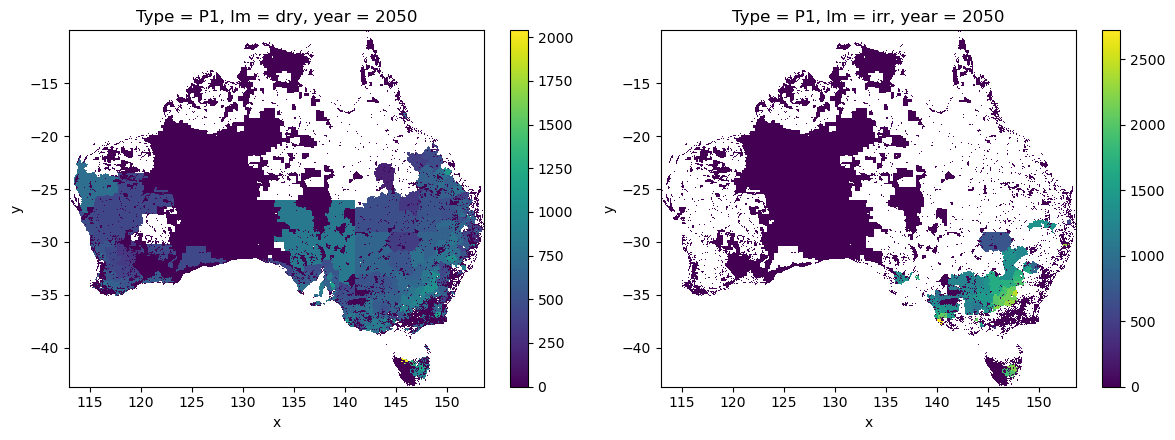

In [ ]:
# HIDE CODE

r_dry = r.sel(lm='dry').drop_vars('spatial_ref')
r_irr = r.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(r_dry, r_irr)

## GHG emmisions

In [ ]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agghg_crops_xr = []
for col in data.AGGHG_CROPS.columns:
    series = data.AGGHG_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agghg_crops_xr.append(series_xr)

# Combine the xarray objects
agghg_crops_xr = xr.combine_by_coords(agghg_crops_xr)            # kg/ha

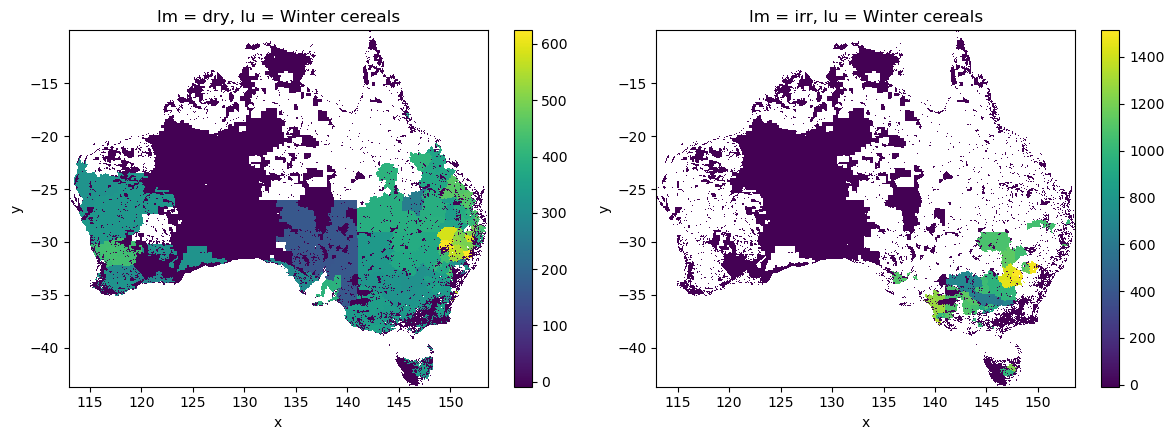

In [ ]:
# HIDE CODE
agghg_crops_xr_lu = agghg_crops_xr.sel(lu=lu_desc).sum(dim=['Type'], skipna=False)    # kg/ha
ghg_dry = agghg_crops_xr_lu.sel(lm='dry').drop_vars('spatial_ref') 
ghg_irr = agghg_crops_xr_lu.sel(lm='irr').drop_vars('spatial_ref') 

plot_dry_irr(ghg_dry, ghg_irr)

## Find the optimized solution

In [ ]:
# REMOVE

c_pred_xr = c_total * lu_area * pred_arr_xr
c_pred_xr_sum = c_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

r_pred_xr = r * lu_area * pred_arr_xr
r_pred_xr_sum = r_pred_xr.sum(dim=['lm','x', 'y']) / 1e9        # billion $

wr_pred_xr = wr_mrj_xr_lu * lu_area * pred_arr_xr               
wr_pred_xr_sum = wr_pred_xr.sum(dim=['lm','x', 'y']) / 1e6      # million ML

ghg_pred_xr = agghg_crops_xr_lu * lu_area * pred_arr_xr         
ghg_pred_xr_sum = ghg_pred_xr.sum(dim=['lm','x', 'y']) / 1e9    # million t

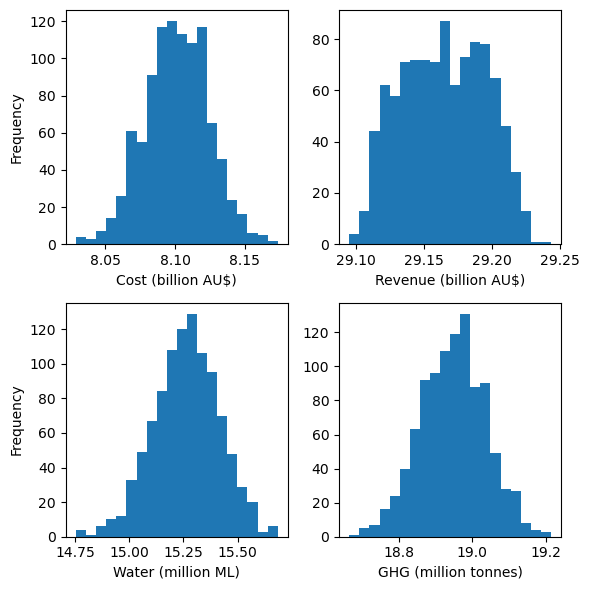

In [ ]:
# HIDE CODE

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()


axs[0].set_ylabel('Frequency')
axs[0].hist(c_pred_xr_sum, bins=20)
axs[0].set_xlabel('Cost (billion AU$)')

axs[1].hist(r_pred_xr_sum, bins=20)
axs[1].set_xlabel('Revenue (billion AU$)')

axs[2].set_ylabel('Frequency')
axs[2].hist(wr_pred_xr_sum, bins=20)
axs[2].set_xlabel('Water (million ML)')

axs[3].hist(ghg_pred_xr_sum, bins=20)
axs[3].set_xlabel('GHG (million tonnes)')


plt.tight_layout()

In [ ]:
# REMOVE

# Set abitrairy water and GHG limits
ghg_lmt = 18.8           # million tonnes
water_lmt = 15           # million ML

runs_lmt = (ghg_pred_xr_sum < ghg_lmt) & (wr_pred_xr_sum < water_lmt)
runs_idx = ghg_pred_xr_sum.coords['run'].values[runs_lmt.values]

In [ ]:
# HIDE CODE

c_df = c_pred_xr_sum[runs_idx].to_dataframe(name='Cost_billion_AUD').reset_index()
r_df = r_pred_xr_sum[runs_idx].to_dataframe(name='Revenue_billion_AUD').reset_index()

c_r_df = pd.merge(c_df, r_df, on=['run'], how='inner')[['run', 'Cost_billion_AUD', 'Revenue_billion_AUD']]
c_r_df['Profit_billion_AUD'] = c_r_df['Revenue_billion_AUD'] - c_r_df['Cost_billion_AUD']
c_r_df

,run,Cost_billion_AUD,Revenue_billion_AUD,Profit_billion_AUD
0,24,8.0678,29.1032,21.0354
1,171,8.0832,29.1643,21.0810
2,178,8.0811,29.1487,21.0676
3,188,8.0994,29.2217,21.1223
4,194,8.0613,29.1081,21.0468
5,259,8.0566,29.1517,21.0951
6,444,8.0318,29.1178,21.0861
7,458,8.0938,29.1129,21.0192
8,511,8.0979,29.1123,21.0143
9,687,8.0497,29.1230,21.0733


In [57]:
# HIDE CODE

c_min_idx = c_r_df['Cost_billion_AUD'].argmin()
c_min_run = c_r_df['run'][c_min_idx]

p_max_idx = c_r_df['Profit_billion_AUD'].argmax()
p_max_run = c_r_df['run'][p_max_idx]

print(f'The run with the minimum cost is {c_min_run}.\nThe run with the maximum profit is {p_max_run}.')

NameError: name 'c_r_df' is not defined

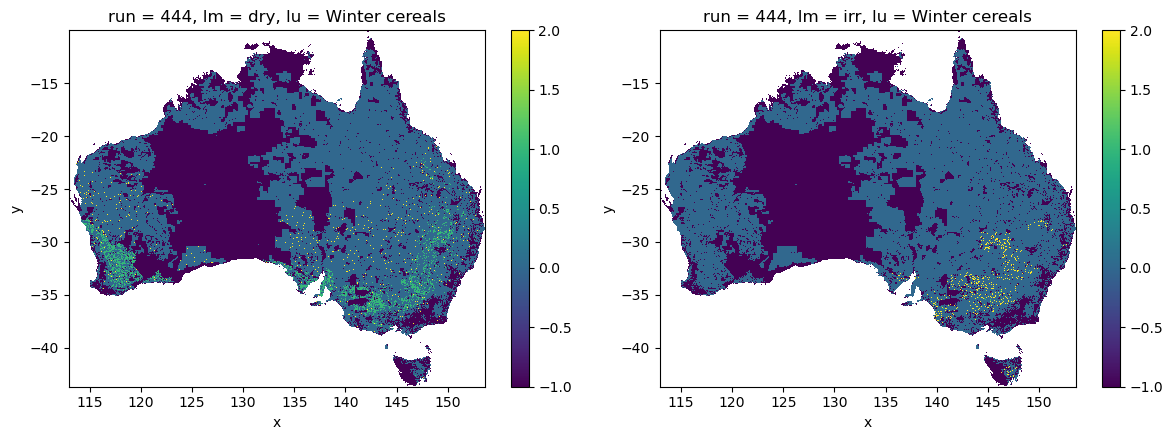

In [ ]:
# HIDE CODE

pred_min_c = pred_arr_xr.sel(run=c_min_run)
pred_min_c_dry = pred_min_c.sel(lm='dry').drop_vars('spatial_ref')
pred_min_c_irr = pred_min_c.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_min_c_dry, pred_min_c_irr)

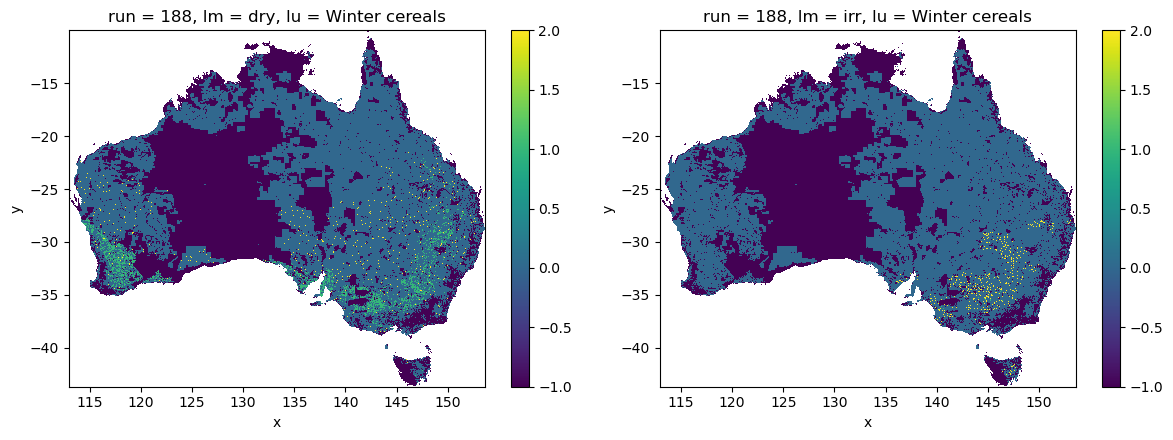

In [ ]:
# HIDE CODE

pred_max_p = pred_arr_xr.sel(run=p_max_run)
pred_max_p_dry = pred_max_p.sel(lm='dry').drop_vars('spatial_ref')
pred_max_p_irr = pred_max_p.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_max_p_dry, pred_max_p_irr)